In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ECG/ptbdb_normal.csv')

In [ ]:
data.head(5)


,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/attn1.pth'
    lstm_state_path = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/lstm.pth'
    cnn_state_path = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/cnn1.pth'

    attn_logs = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/attn1.csv'
    lstm_logs = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/lstm.csv'
    cnn_logs = '/content/drive/MyDrive/ECG//mitbih_with_synthetic/cnn1.csv'

    train_csv_path = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/mitbih_with_syntetic_train.csv'
    test_csv_path = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/mitbih_with_syntetic_test.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [ ]:
df_ptbdb = pd.read_csv('/content/drive/MyDrive/ECG/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('/content/drive/MyDrive/ECG/mitbih_train.csv')
df_ptbdb

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10501,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_mitbih_train = pd.read_csv('/content/drive/MyDrive/ECG/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/content/drive/MyDrive/ECG/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

# Basic EDA

In [ ]:
df_mitbih = pd.read_csv(config.csv_path)
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

<ipython-input-11-45d82733c822>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-11-45d82733c822>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15);


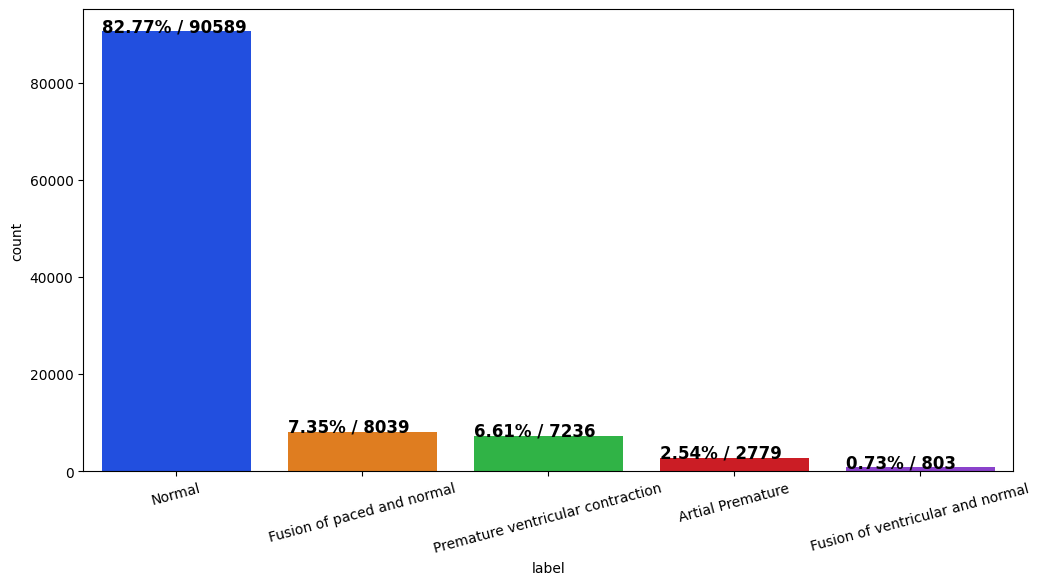

In [ ]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')

plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
config.csv_path = '/content/drive/MyDrive/ECG/mitbih_with_synthetic/mitbih_with_syntetic.csv'
df_mitbih_new = pd.read_csv(config.csv_path)

<ipython-input-13-ecdde89da633>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-13-ecdde89da633>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=15);
<ipython-input-13-ecdde89da633>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-13-ecdde89da633>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=15);


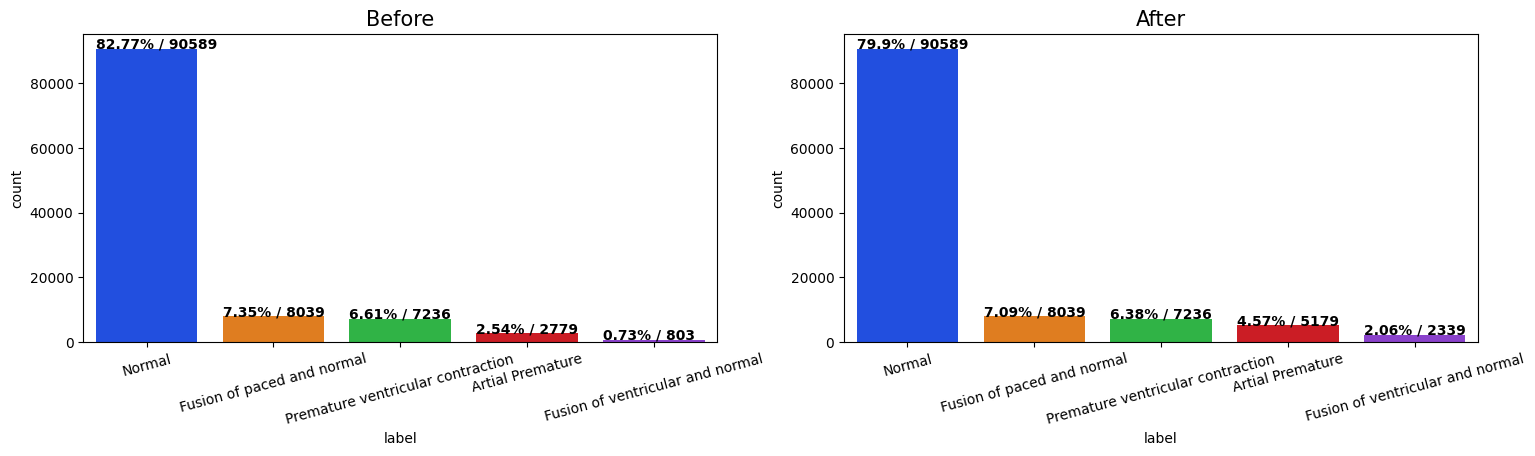

In [ ]:
percentages1 = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]
percentages2 = [count / df_mitbih_new.shape[0] * 100 for count in df_mitbih_new['label'].value_counts()]

fig, axs = plt.subplots(1,2, figsize=(18, 4))

# origin
sns.countplot(
    x=df_mitbih['label'],
    ax=axs[0],
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=15);
axs[0].set_title("Before", fontsize=15)

for percentage, count, p in zip(
    percentages1,
    df_mitbih['label'].value_counts(sort=True).values,
    axs[0].patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    axs[0].annotate(str(percentage)+" / "+str(count), (x, y), fontsize=10, fontweight='bold')

# with synthetic
sns.countplot(
    x=df_mitbih_new['label'],
    ax=axs[1],
    palette="bright",
    order=df_mitbih_new['label'].value_counts().index
)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=15);
axs[1].set_title("After", fontsize=15)

for percentage, count, p in zip(
    percentages2,
    df_mitbih_new['label'].value_counts(sort=True).values,
    axs[1].patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    axs[1].annotate(str(percentage)+" / "+str(count), (x, y), fontsize=10, fontweight='bold')

#plt.suptitle("Balanced Sampling between classes", fontsize=20, weight="bold", y=1.01)
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

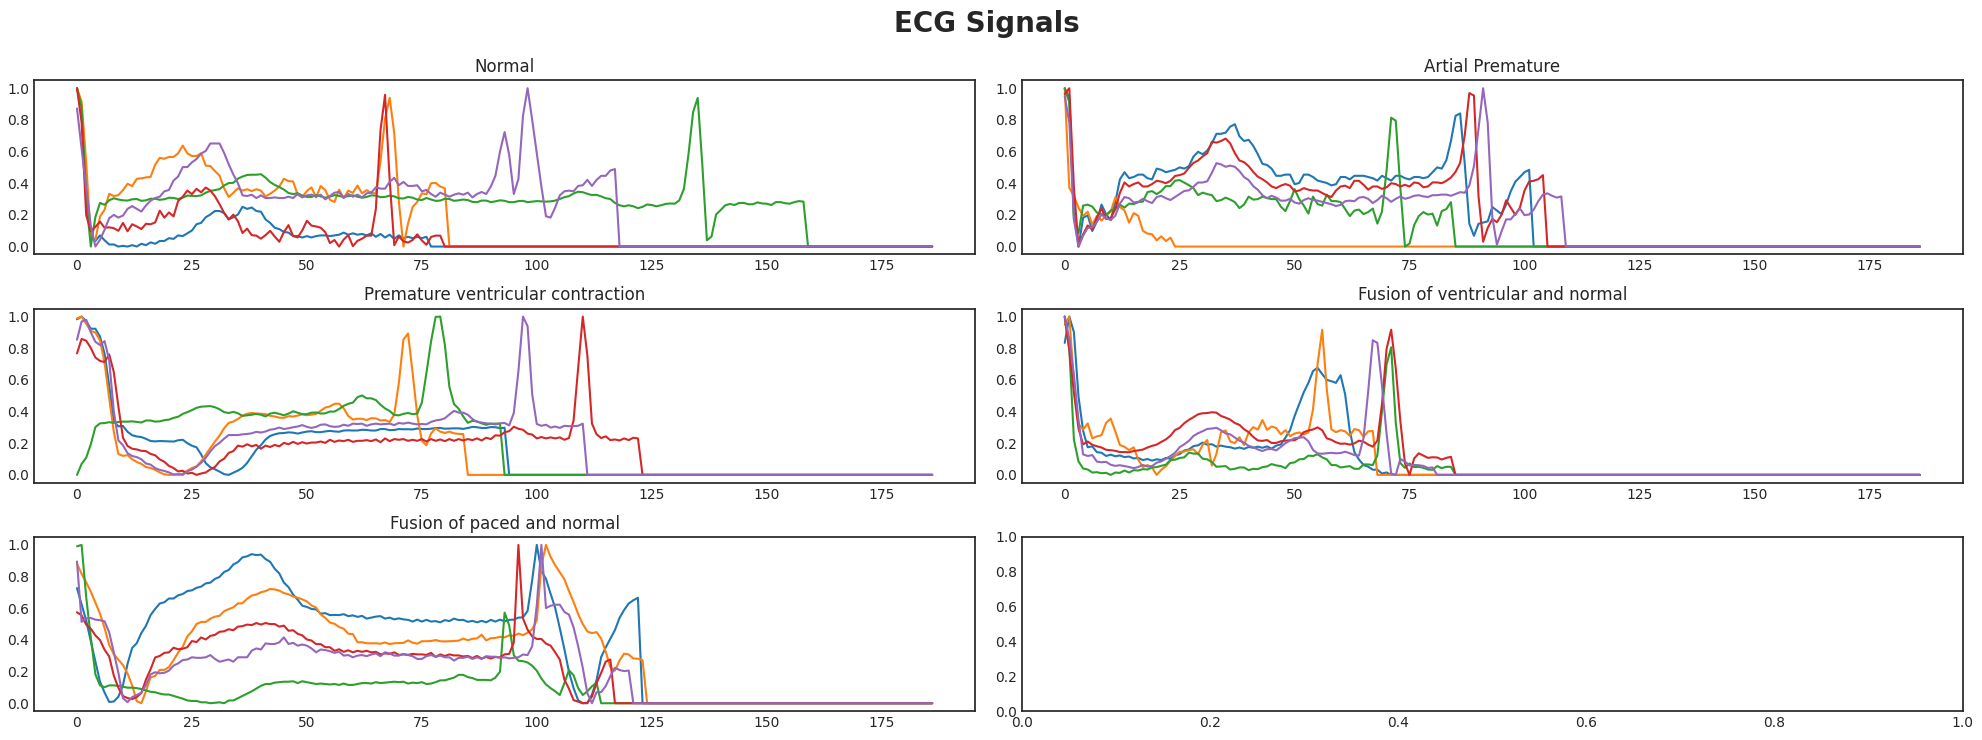

In [ ]:
N = 5
samples = [df_mitbih.loc[df_mitbih['class'] == cls].sample(N) for cls in range(N)]
titles = [id_to_label[cls] for cls in range(5)]

with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
    plt.savefig(f"signals_per_class.svg",
                    format="svg",bbox_inches='tight', pad_inches=0.2)

    plt.savefig(f"signals_per_class.png",
                    format="png",bbox_inches='tight', pad_inches=0.2)

In [ ]:
%%time
signals = [' '.join(df_mitbih.iloc[i, :-1].apply(str).values) for i in range(df_mitbih.shape[0])]
y = df_mitbih.iloc[:, -1].values.tolist()
print(len(signals), len(y))

print(f'data has {len(set([sig for line in signals for sig in line.split()]))} out of 16 372 411 unique values.')

109446 109446
data has 279149 out of 16 372 411 unique values.
CPU times: user 1min 18s, sys: 3.66 s, total: 1min 22s
Wall time: 1min 20s


## Dataset and DataLoader

In [ ]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [ ]:
def get_dataloader(phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

# Models

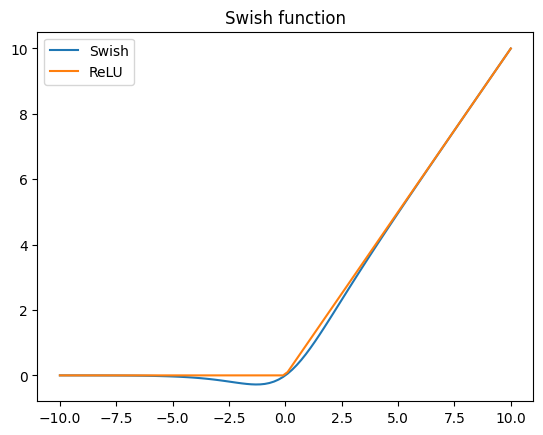

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

In [ ]:
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)

    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):

        super().__init__()

        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

In [ ]:
class RNN(nn.Module):
    """RNN module(cell type lstm or gru)"""
    def __init__(
        self,
        input_size,
        hid_size,
        num_rnn_layers=1,
        dropout_p = 0.2,
        bidirectional = False,
        rnn_type = 'lstm',
    ):
        super().__init__()

        if rnn_type == 'lstm':
            self.rnn_layer = nn.LSTM(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )

        else:
            self.rnn_layer = nn.GRU(
                input_size=input_size,
                hidden_size=hid_size,
                num_layers=num_rnn_layers,
                dropout=dropout_p if num_rnn_layers>1 else 0,
                bidirectional=bidirectional,
                batch_first=True,
            )
    def forward(self, input):
        outputs, hidden_states = self.rnn_layer(input)
        return outputs, hidden_states

In [ ]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,#hid_size * 2 if bidirectional else hid_size,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x, _ = self.rnn_layer(x)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)#.squeeze(1)
        return x

In [ ]:

class RNNAttentionModel(nn.Module):
    def __init__(
        self,
        input_size,
        hid_size,
        rnn_type,
        bidirectional,
        n_classes=5,
        kernel_size=5,
    ):
        super().__init__()

        self.rnn_layer = RNN(
            input_size=46,
            hid_size=hid_size,
            rnn_type=rnn_type,
            bidirectional=bidirectional
        )
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveMaxPool1d((1))
        self.attn = nn.Linear(hid_size, hid_size, bias=False)
        self.fc = nn.Linear(in_features=hid_size, out_features=n_classes)

    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x_out, hid_states = self.rnn_layer(x)
        x = torch.cat([hid_states[0], hid_states[1]], dim=0).transpose(0, 1)
        x_attn = torch.tanh(self.attn(x))
        x = x_attn.bmm(x_out)
        x = x.transpose(2, 1)
        x = self.avgpool(x)
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=-1)
        return x

# Training Stage

In [ ]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion

In [ ]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)

            output = self.net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()


In [ ]:
model = RNNAttentionModel(1, 64, 'lstm', False)
#model = RNNModel(1, 64, 'lstm', True)
#model = CNN(num_classes=5, hid_size=128)

In [ ]:
trainer = Trainer(net=model, lr=1e-3, batch_size=64, num_epochs=10)#100)
#trainer.run()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train mode | time: 07:16:59


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 1.011407020410772, accuracy: 0.8953510122534254, f1: 0.5321302100116155, precision: 0.5385943869116425, recall: 0.9369735442101141


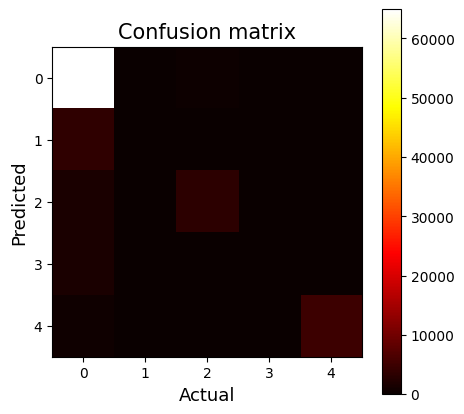

val mode | time: 07:18:33


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9989606298340692, accuracy: 0.9141581384015595, f1: 0.5883564180093088, precision: 0.581007281699976, recall: 0.9667429398835207


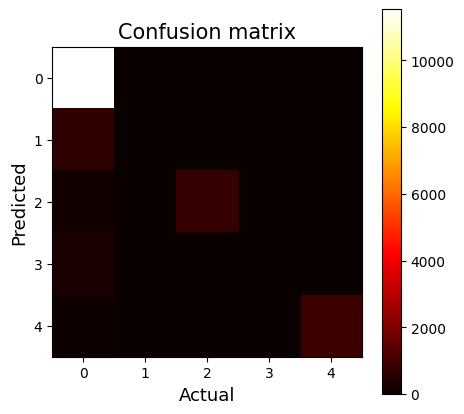


New checkpoint

train mode | time: 07:18:49


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9916103965514708, accuracy: 0.9145921185864981, f1: 0.5875991915796012, precision: 0.5973844922887037, recall: 0.949917277802337


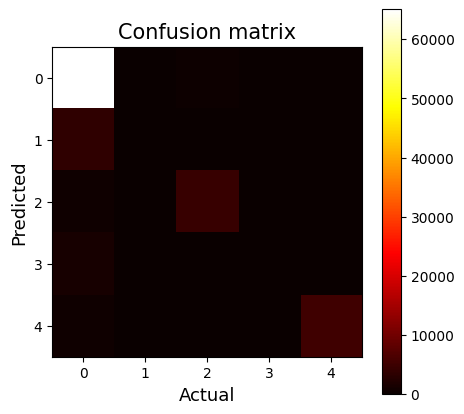

val mode | time: 07:20:22


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9971739093462626, accuracy: 0.915816276803119, f1: 0.587127391097826, precision: 0.5947138724001024, recall: 0.9463201982020069


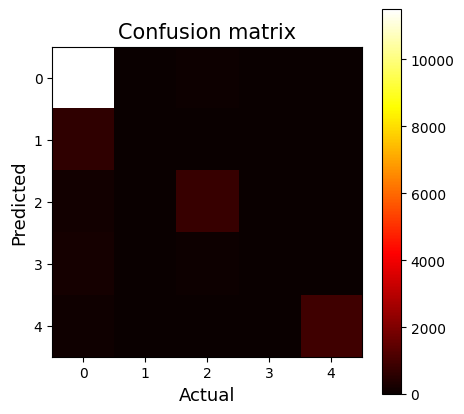

train mode | time: 07:20:38


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9892357640475198, accuracy: 0.9168644016201181, f1: 0.5920007255015366, precision: 0.602405962153047, recall: 0.9517842095982366


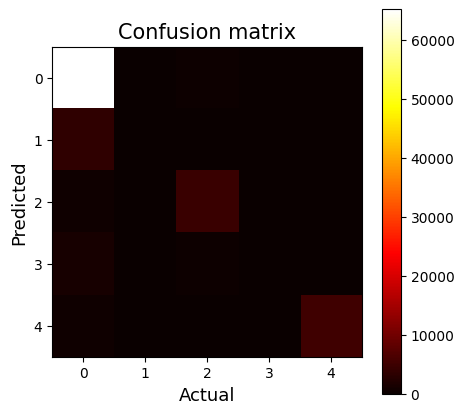

val mode | time: 07:22:11


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9926393506262038, accuracy: 0.9204081384015594, f1: 0.6001707440556847, precision: 0.6058924757812219, recall: 0.9576864042591141


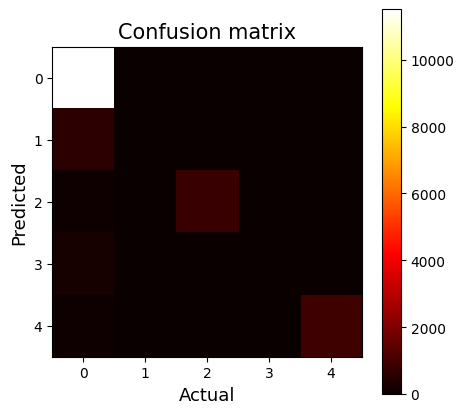


New checkpoint

train mode | time: 07:22:27


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9866655112897352, accuracy: 0.9194665321908765, f1: 0.5981539656764479, precision: 0.6075915340711445, recall: 0.9568788731081849


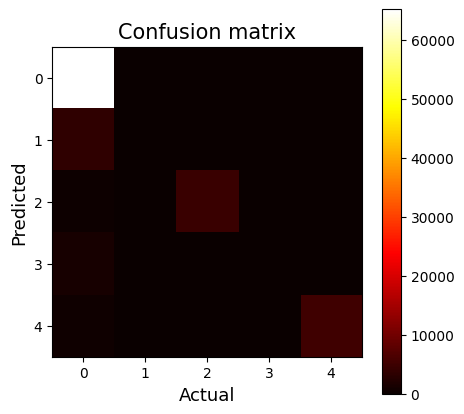

val mode | time: 07:24:02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9905234408378601, accuracy: 0.9222831384015594, f1: 0.6054854600204239, precision: 0.6149122388112311, recall: 0.9582656164492289


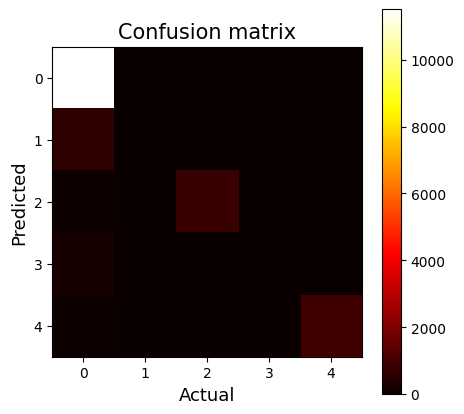

train mode | time: 07:24:19


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.9852579521238105, accuracy: 0.9209203046693754, f1: 0.6019793501502171, precision: 0.6117359314473207, recall: 0.9590306217072684


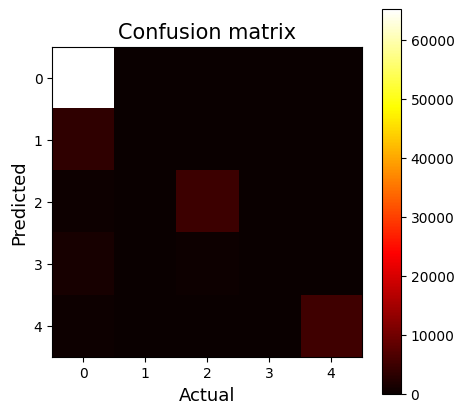

val mode | time: 07:25:53


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

loss: 0.988482829729716, accuracy: 0.9246442495126705, f1: 0.6078189920320997, precision: 0.6200790120164742, recall: 0.957509400403047


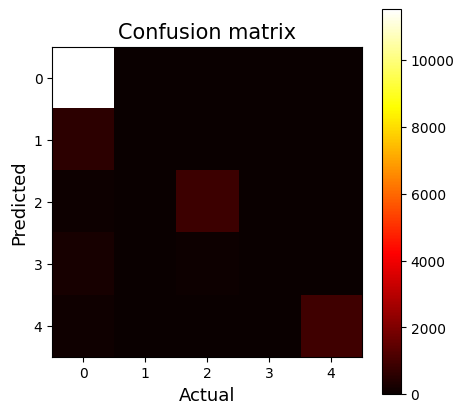


New checkpoint

train mode | time: 07:26:09


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-16-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with nump

KeyboardInterrupt: 

In [ ]:
trainer.run()

In [ ]:
trainer = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=10)#100)
train_logs = trainer.train_df_logs
train_logs.columns = ["train_"+ colname for colname in train_logs.columns]
val_logs = trainer.val_df_logs
val_logs.columns = ["val_"+ colname for colname in val_logs.columns]

logs = pd.concat([train_logs,val_logs], axis=1)
logs.reset_index(drop=True, inplace=True)
logs = logs.loc[:, [
    'train_loss', 'val_loss',
    'train_accuracy', 'val_accuracy',
    'train_f1', 'val_f1',
    'train_precision', 'val_precision',
    'train_recall', 'val_recall']
                                 ]
logs.head()
logs.to_csv('attn1.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyError: ignored

# Experiments and Results

In [ ]:
cnn_model = CNN(num_classes=5, hid_size=128).to(config.device)
cnn_model.load_state_dict(
    torch.load(config.cnn_state_path,
               map_location=config.device)
);
cnn_model.eval();
logs = pd.read_csv(config.cnn_logs)

EOFError: ignored

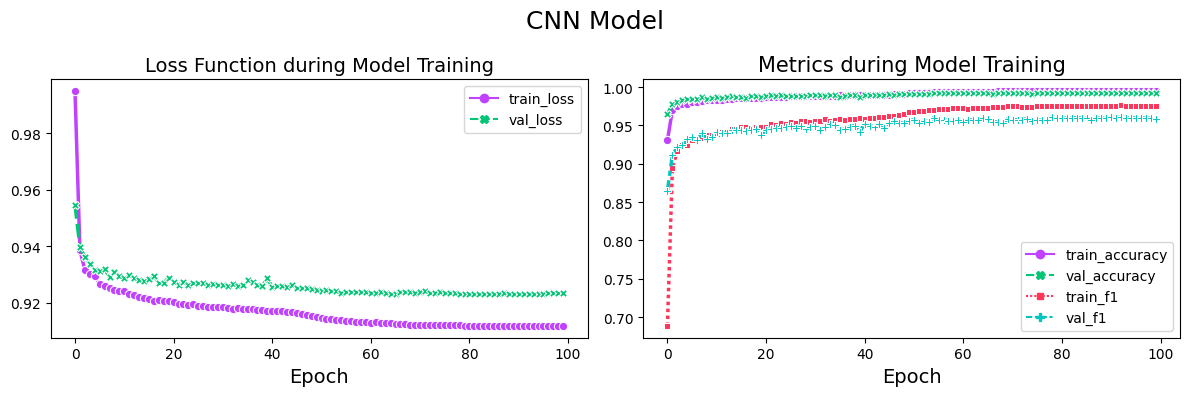

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4),
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN Model', fontsize=18)

plt.tight_layout()
fig.savefig("cnn.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
lstm_model = RNNModel(1, 64, 'lstm', True).to(config.device)
lstm_model.load_state_dict(
    torch.load(config.lstm_state_path,
               map_location=config.device)
);
lstm_model.eval();
logs = pd.read_csv(config.lstm_logs)

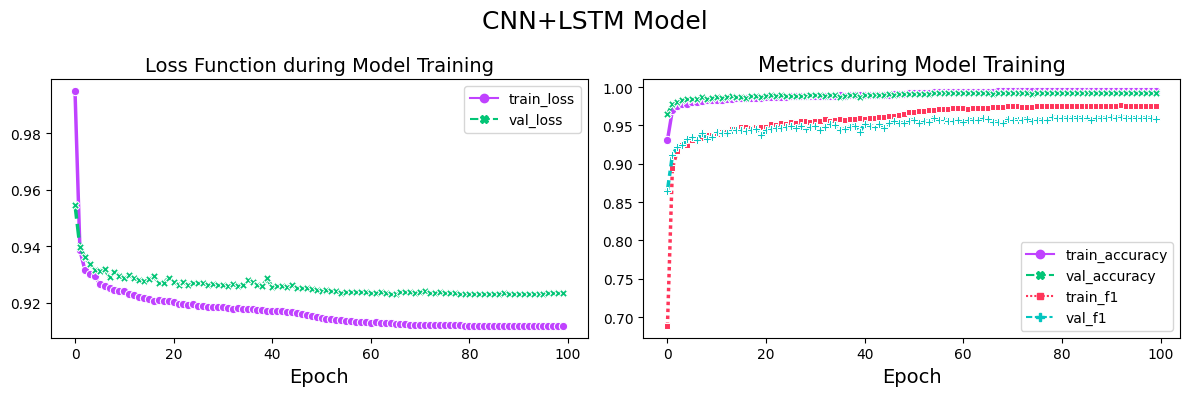

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4),
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN+LSTM Model', fontsize=18)

plt.tight_layout()
fig.savefig("lstm.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
attn_model = RNNAttentionModel(1, 64, 'lstm', False).to(config.device)
attn_model.load_state_dict(
    torch.load(config.attn_state_path,
               map_location=config.device)
);
attn_model.eval();
logs = pd.read_csv(config.attn_logs)

EmptyDataError: ignored

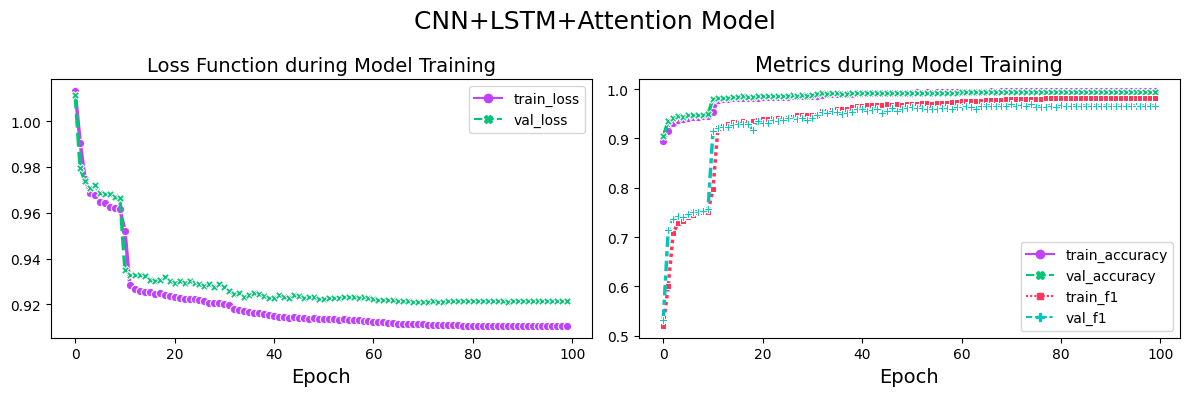

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4),
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN+LSTM+Attention Model', fontsize=18)

plt.tight_layout()
fig.savefig("attn.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

## Experiments and Results for Test Stage

In [ ]:
test_df = pd.read_csv(config.test_csv_path)
print(test_df.shape)
test_dataset = ECGDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=96, num_workers=0, shuffle=False)


(17008, 189)


In [ ]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls

In [ ]:
models = [cnn_model, lstm_model, attn_model]


### cnn model report

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):

    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

### cnn+lstm model report

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[1])
y_pred.shape, y_true.shape

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):

    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("lstm_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("lstm_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

### cnn+lstm+attention model report

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[2])
y_pred.shape, y_true.shape

<ipython-input-10-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  signal = torch.FloatTensor([signal.values])


((17008,), (17008,))

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

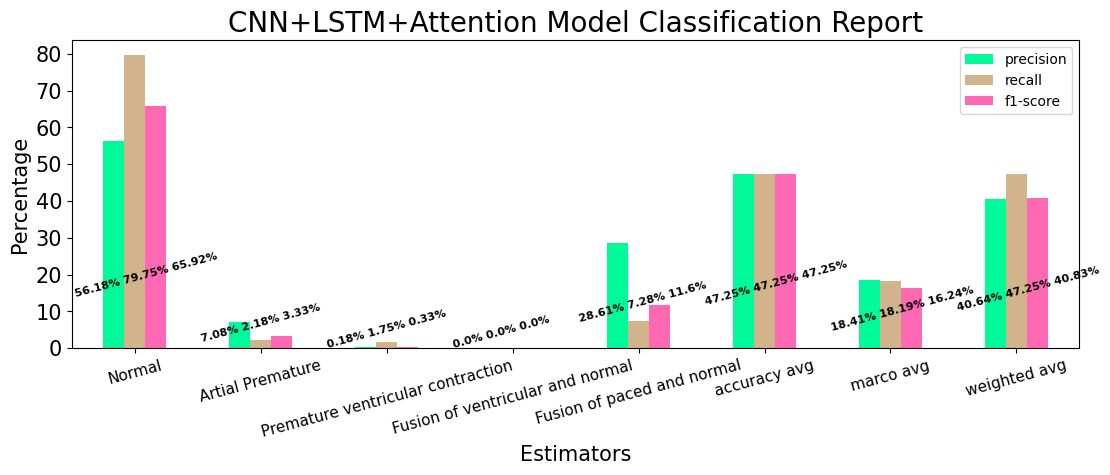

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN+LSTM+Attention Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):

    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("attn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("attn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

### Ensemble of all models

In [ ]:
y_pred = np.zeros((y_pred.shape[0], 5), dtype=np.float32)
for i, model in enumerate(models, 1):
    y_pred_, y_true = make_test_stage(test_dataloader, model, True)
    y_pred += y_pred_
y_pred /= i
y_pred = np.argmax(y_pred, axis=1)

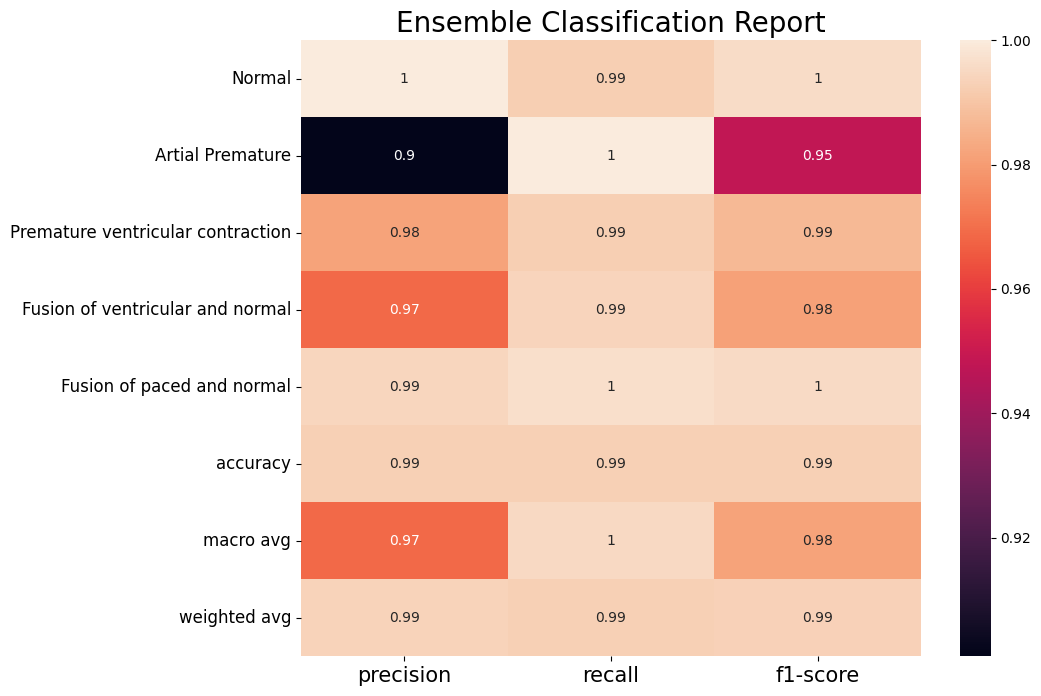

In [ ]:
clf_report = classification_report(y_pred,
                                   y_true,
                                   labels=[0,1,2,3,4],
                                   target_names=list(id_to_label.values()),#['N', 'S', 'V', 'F', 'Q'],
                                   output_dict=True)


plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("Ensemble Classification Report", fontsize=20)
plt.savefig(f"ensemble result.svg",format="svg",bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"ensemble result.png", format="png",bbox_inches='tight', pad_inches=0.2)

In [ ]:
clf_report

{'Normal': {'precision': 0.9997056442711016,
  'recall': 0.9923301680058437,
  'f1-score': 0.9960042523552918,
  'support': 13690},
 'Artial Premature': {'precision': 0.9009009009009009,
  'recall': 1.0,
  'f1-score': 0.947867298578199,
  'support': 700},
 'Premature ventricular contraction': {'precision': 0.9815668202764977,
  'recall': 0.9925442684063374,
  'f1-score': 0.9870250231696015,
  'support': 1073},
 'Fusion of ventricular and normal': {'precision': 0.9686609686609686,
  'recall': 0.9941520467836257,
  'f1-score': 0.9812409812409812,
  'support': 342},
 'Fusion of paced and normal': {'precision': 0.9941956882255389,
  'recall': 0.9966749792186201,
  'f1-score': 0.9954337899543377,
  'support': 1203},
 'accuracy': 0.9930032925682032,
 'macro avg': {'precision': 0.9690060044670016,
  'recall': 0.9951402924828854,
  'f1-score': 0.9815142690596822,
  'support': 17008},
 'weighted avg': {'precision': 0.9934808068600698,
  'recall': 0.9930032925682032,
  'f1-score': 0.993119381379